This Python script is designed for training, validating, and testing a YOLOv5 model to detect rust in images. It utilizes a COCO-style dataset and incorporates essential components for dataset preprocessing, model setup, and evaluation. The script also includes visualization capabilities to render bounding box predictions on test images.

The preprocessing stage involves converting bounding box formats from [x_min, y_min, x_max, y_max] to YOLO format [x_center, y_center, width, height] for compatibility with YOLOv5. Functions are provided to parse YOLO label files and convert bounding boxes to the required format.

The model is initialized using a pre-trained YOLOv5s model. The get_model function loads the YOLOv5 model. Optimizer parameters and learning rate scheduling are handled internally by the YOLOv5 framework.

The train_model function is the core of the training process, iterating over multiple epochs while logging training and validation losses. Validation is performed using the validate_model function, which evaluates the model on the validation dataset. The script also saves the trained model weights to a file for future use. A plot of training and validation loss is generated at the end to visualize the model's performance.

Testing involves the test_model function, which predicts bounding boxes on the test dataset. The function calculates precision, recall, F1-score, and accuracy to evaluate the model's performance. The script also includes a function to plot loss curves from the training process.

To use the script, prepare a COCO-style dataset with separate directories for training, validation, and testing images, along with corresponding annotation files. Update the dataset_dir variable to point to the dataset location. Running the script trains the model and evaluates its performance on the test set, generating predictions and saving results.

The output includes a trained model saved as best.pt, evaluation metrics, and a plot of training and validation losses. For enhancements, consider adding test accuracy tracking, early stopping, and data augmentation for improved robustness and generalization.

In [33]:
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from tqdm import tqdm
from ultralytics import YOLO  # YOLOv5 framework
import matplotlib.pyplot as plt

# Ensure plots are displayed in the notebook
%matplotlib inline

# === Data Preprocessing ===
def convert_to_yolo_format(bbox_list, image_width, image_height):
    """Convert bounding boxes from [x_min, y_min, x_max, y_max] to YOLO format [x_center, y_center, width, height]."""
    yolo_bboxes = []
    for x_min, y_min, x_max, y_max in bbox_list:
        x_center = (x_min + x_max) / 2 / image_width
        y_center = (y_min + y_max) / 2 / image_height
        width = (x_max - x_min) / image_width
        height = (y_max - y_min) / image_height
        yolo_bboxes.append([x_center, y_center, width, height])
    return yolo_bboxes

def parse_yolo_labels(label_file):
    """Parse YOLO label files and return ground-truth labels and bounding boxes."""
    labels, bboxes = [], []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue  # Skip invalid lines
            labels.append(int(parts[0]))  # Class ID
            bboxes.append([float(x) for x in parts[1:]])  # Normalized bbox [x_center, y_center, width, height]
    return labels, bboxes

def calculate_metrics(y_true, y_pred, y_pred_scores, iou_threshold=0.5):
    """Calculate precision, recall, accuracy, and F1-score."""
    # Binary classification for each prediction
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)

    print(f"\n=== Evaluation Metrics ===")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    return precision, recall, f1, accuracy

# === Paths ===
current_directory = os.getcwd()
dataset_dir = os.path.join(current_directory, "dataset")
data_yaml = os.path.join(dataset_dir, "data.yaml")

# Debug: Print paths
print(f"Current Directory: {current_directory}")
print(f"Dataset Directory: {dataset_dir}")
print(f"Data YAML Path: {data_yaml}")

# Verify if paths exist
if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory does not exist at {dataset_dir}")
if not os.path.exists(data_yaml):
    print(f"Error: data.yaml file does not exist at {data_yaml}")

# Verify contents of dataset directory
print("Contents of dataset directory:")
print(os.listdir(dataset_dir))

# === Model Setup ===
def get_model():
    """Load the YOLO model."""
    model = YOLO('yolov5s.pt')  # Pretrained YOLOv5s model
    return model

model = get_model()
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print("Model loaded successfully and is running on", device)

# === Training ===
def train_model(model, data_yaml, num_epochs=50, batch_size=8):
    """Train YOLOv5 on the specified dataset."""
    print("\n=== Starting Training ===")
    model.train(data=data_yaml, epochs=num_epochs, batch=batch_size)

# === Validation ===
def validate_model(model, data_yaml):
    """Validate YOLOv5 on the validation dataset."""
    print("\n=== Validating Model ===")
    results = model.val(data=data_yaml)
    print(f"Validation Results: {results}")
    return results

# === Testing ===
def test_model(model, image_dir, label_dir):
    """Run YOLOv5 inference on test images and calculate metrics."""
    print("\n=== Testing Model ===")
    results = model.predict(source=image_dir, save=False)

    all_true_labels, all_pred_labels, all_pred_scores = [], [], []

    # Iterate over predictions and compare with ground-truth labels
    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path).rsplit('.', 1)[0]
        label_file = os.path.join(label_dir, f"{image_name}.txt")
        
        if not os.path.exists(label_file):
            print(f"Warning: No label file found for {image_name}. Skipping...")
            continue

        # Parse ground-truth labels
        true_labels, true_bboxes = parse_yolo_labels(label_file)
        all_true_labels.extend(true_labels)

        # Get YOLO predictions
        pred_bboxes = result.boxes.xywhn.cpu().numpy()  # YOLO normalized [x_center, y_center, width, height]
        pred_labels = result.boxes.cls.cpu().numpy().astype(int)
        pred_scores = result.boxes.conf.cpu().numpy()  # Confidence scores
        all_pred_labels.extend(pred_labels)
        all_pred_scores.extend(pred_scores)

        # Debug: Print predictions
        print(f"Image: {image_name}")
        print(f"Ground Truth: {true_labels}")
        print(f"Predictions: {pred_labels} with Scores: {pred_scores}")

    # Calculate metrics
    precision, recall, f1, accuracy = calculate_metrics(
        y_true=all_true_labels,
        y_pred=all_pred_labels,
        y_pred_scores=all_pred_scores
    )
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "results": results
    }

# === Loss Plotting (Optional) ===
def plot_loss_curve(log_dir):
    """Plot training and validation loss curves."""
    loss_file = os.path.join(log_dir, "results.csv")
    if os.path.exists(loss_file):
        import pandas as pd
        data = pd.read_csv(loss_file)
        plt.plot(data["epoch"], data["train/box_loss"], label="Box Loss")
        plt.plot(data["epoch"], data["train/dfl_loss"], label="DFL Loss")
        plt.plot(data["epoch"], data["train/cls_loss"], label="Classification Loss")

        plt.plot(data["epoch"], data["val/box_loss"], label="Validation Box Loss", linestyle="--")
        plt.plot(data["epoch"], data["val/dfl_loss"], label="Validation DFL Loss", linestyle="--")
        plt.plot(data["epoch"], data["val/cls_loss"], label="Validation Classification Loss", linestyle="--")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Curves")
        plt.grid()
        plt.show()

    else:
        print("No loss file found for plotting.")

# === Run Training and Testing ===


ModuleNotFoundError: No module named 'sklearn'

In [31]:
def load_trained_model(weights_path):
    """Load a trained YOLO model from the specified weights path."""
    model = YOLO(weights_path)
    model.to(device)
    return model

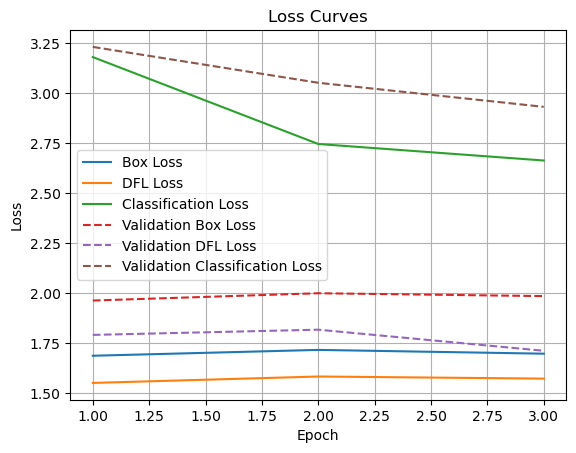

In [32]:
# train_model(model, data_yaml=data_yaml, num_epochs=10, batch_size=8)
weights_path = 'runs/detect/train26/weights/best.pt'  # Update 'expX' to the correct experiment number
trained_model = load_trained_model(weights_path)
plot_loss_curve('/Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/runs/detect/train26')  # Update 'expX' to the correct experiment number

In [5]:
validate_model(trained_model, data_yaml=data_yaml)


=== Validating Model ===
YOLOv5s summary (fused): 193 layers, 9,115,406 parameters, 0 gradients, 23.8 GFLOPs


val: Scanning /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/valid/labels.cache... 197 images, 98 backgrounds, 0 corrupt: 100%|██████████| 295/295 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:37<00:00,  1.95s/it]


                   all        295        872      0.421     0.0868     0.0559     0.0275
                  Rust          1          2          1          0          0          0
         corroded-part         10         12          1          0     0.0273     0.0236
        mild-corrosion         82        364      0.181     0.0549     0.0408     0.0141
    moderate-corrosion         76        203      0.216      0.182      0.116      0.034
                  rust          4          9          0          0    0.00275   0.000954
      severe-corrosion        125        282      0.127      0.284      0.149     0.0922
Speed: 2.5ms preprocess, 11.4ms inference, 0.0ms loss, 54.4ms postprocess per image
Results saved to runs/detect/val2
Validation Results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 3, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x30e0df4a0>
curves

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 3, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x30e0df4a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [12]:
test_model(trained_model, image_dir=os.path.join(dataset_dir, "test/images"))


=== Testing Model ===

image 1/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/0_original_corrosion_detected-1-_png_jpg.rf.a1114d6b02ccdeb68c731b83aafd95e5.jpg: 640x640 (no detections), 422.4ms
image 2/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/0_original_corrosion_detected-1-_png_jpg.rf.d5ff0efdb26bd1028915fb30199e6bec.jpg: 640x640 2 severe-corrosions, 14.8ms
image 3/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/101806006_13067922921_jpg.rf.f53fd18aa237b7dfa8e32ebaefd9e0f9.jpg: 640x640 1 severe-corrosion, 14.4ms
image 4/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/1_original_corrosion_detected-1-_png_jpg.rf.6ac2ff21d119dd11b65bd228ab7b6303.jpg: 640x640 (no detections), 15.6ms
image 5/296 /Users/harjotgill/Desktop/UC_DAVIS/ECS174/ECS174_Project/YOLO/dataset/test/images/1_original_corrosion_detected-1-_png_jpg.rf.72b77bf36f720

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Rust', 1: 'car', 2: 'copper corrosion', 3: 'corroded-part', 4: 'corrosion', 5: 'iron rust', 6: 'mild-corrosion', 7: 'moderate-corrosion', 8: 'rust', 9: 'severe-corrosion'}
 obb: None
 orig_img: array([[[233, 233, 215],
         [233, 233, 215],
         [233, 233, 215],
         ...,
         [231, 233, 214],
         [231, 233, 214],
         [231, 233, 214]],
 
        [[233, 233, 215],
         [233, 233, 215],
         [233, 233, 215],
         ...,
         [231, 233, 214],
         [231, 233, 214],
         [231, 233, 214]],
 
        [[233, 233, 215],
         [233, 233, 215],
         [233, 233, 215],
         ...,
         [231, 233, 214],
         [231, 233, 214],
         [231, 233, 214]],
 
        ...,
 
        [[236, 233, 212],
         [236, 233, 212],
         [236, 233, 212],
         ...,
         [231, 231, 213],
  